# Applications of Reinforcement Learning in Finance - Deep Q-learning & the S&P500

## Imports & Settings

### Imports

In [1]:
# from google.colab import drive
# drive.mount('/content/gdrive')
# %cd /content/gdrive/MyDrive/

from pathlib import Path
results_path = Path('result')        # Results directory
if not results_path.exists():         # Set up if not existing
  results_path.mkdir(parents=True)

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from time import time
from collections import deque
from random import sample
from psutil import virtual_memory
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

import gym
from gym.envs.registration import register

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

  # Use GPU if available
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('Using CPU')

2024-02-25 16:21:06.802898: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Sun Feb 25 16:21:22 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.43.04    Driver Version: 515.43.04    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:04:00.0 Off |                    0 |
| N/A   31C    P0    31W / 250W |      0MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla P100-PCIE...  Off  | 00000000:05:00.0 Off |                    0 |
| N/A   

### Parameters

In [2]:
model = 3                           # Model for Testing


total_steps = 0
max_episodes = 50                  # Episodes to train (change to 1000)

gamma = 0.90                        # discount factor
tau = 100                           # target network update frequency

## NN Architecture
architecture = (64, 64)             # units per layer (maybe 256)
learning_rate = 0.0001              # learning rate
l2_reg = 1e-6                       # L2 regularization

## Experience Replay
replay_capacity = int(1e6)          # Capacity
batch_size = 4096                   # for training set to 4096, the batch size to train the NNs on

## epsilon-greedy Policy
epsilon_start = 1.0                 # epsilon start value
epsilon_end = .01                   # where it stops
epsilon_decay_steps = 250           # steps to decay
epsilon_exponential_decay = .99     # exponential decay multiplicator

trading_cost_bps = 1e-4
time_cost_bps = 1e-5
f'Trading costs: {trading_cost_bps:.2%} | Time costs: {time_cost_bps:.3%}'

'Trading costs: 0.01% | Time costs: 0.001%'

### Settings

In [3]:
## Helper Function+
np.random.seed(41)                              # Set Random
tf.random.set_seed(41)                          # Set Random

sns.set_style('whitegrid')                      # Plot Style

def format_time(t):                             # Helper Function
    m_, s = divmod(t, 60)
    h, m = divmod(m_, 60)
    return '{:02.0f}:{:02.0f}:{:02.0f}'.format(h, m, s)

## Set up Gym Environment
trading_days = 252
register(
    id='trading-v0',
    entry_point = "trading_env:TradingEnvironment",
    max_episode_steps=trading_days)



## Initialize Trading Environment

trading_environment = gym.make('trading-v0',
                               ticker='SPX',
                               trading_days=trading_days,
                               trading_cost_bps=trading_cost_bps,
                               time_cost_bps=time_cost_bps,
                               model = model)
trading_environment.seed(41)

# state_dim = trading_environment.observation_space                   # Input Nodes
# Alex edit
state_dim = trading_environment.observation_space.shape[0]
num_actions = trading_environment.action_space.n                    # Number of Actions
max_episode_steps = trading_environment.spec.max_episode_steps      # Episode Length (252)

if state_dim == 2:
  print("Model 0,", "Episodes :" + str(max_episodes))
elif state_dim == 4:
  print("Model 1,", "Episodes :" + str(max_episodes))
elif state_dim == 6:
  print("Model 2,", "Episodes :" + str(max_episodes))
elif state_dim == 8:
  print("Model 3,", "Episodes :" + str(max_episodes))

INFO:trading_env:trading_env logger started.
INFO:trading_env:loading data for SPX...
INFO:trading_env:got data for SPX...
INFO:trading_env:loading data for RUS...
INFO:trading_env:got data for RUS...
INFO:trading_env:loading data for WTI...
INFO:trading_env:got data for WTI...
INFO:trading_env:loading data for GOLD...
INFO:trading_env:got data for GOLD...


Model 3, Episodes :50


## Trading Agent

### Define Trading Agent

In [4]:
class DDQNAgent:
    def __init__(self, state_dim,
                 num_actions,
                 learning_rate,
                 gamma,
                 epsilon_start,
                 epsilon_end,
                 epsilon_decay_steps,
                 epsilon_exponential_decay,
                 replay_capacity,
                 architecture,
                 l2_reg,
                 tau,
                 batch_size):

        self.state_dim = state_dim                              # Input Nodes
        self.num_actions = num_actions                          # Number of Actions
        self.experience = deque([], maxlen=replay_capacity)     # Where to store trained data
        self.learning_rate = learning_rate                      # DDQN learning rate
        self.gamma = gamma                                      # Discountfactor for future Rewards
        self.architecture = architecture                        # Architecture of the DDQN
        self.l2_reg = l2_reg

        self.online_network = self.build_model()                # Trainable Network
        self.target_network = self.build_model(trainable=False) # Target Network (Second Network)
        self.update_target()                                    # Update Target Network with weight of Online Network

        self.epsilon = epsilon_start                            # Epsilon = 1
        self.epsilon_decay_steps = epsilon_decay_steps          # Decay steps of Epsilon
        self.epsilon_decay = (epsilon_start - epsilon_end) / epsilon_decay_steps    # How much to decay.
        self.epsilon_exponential_decay = epsilon_exponential_decay
        self.epsilon_history = []                               # Store epsilon values

        self.total_steps = self.train_steps = 0                         # Number of steps taken
        self.episodes = self.episode_length = self.train_episodes = 0   # Number of episodes
        self.steps_per_episode = []
        self.episode_reward = 0
        self.rewards_history = []

        self.batch_size = batch_size        # Number of batches for DDQN to train
        self.tau = tau                      # Steps until the update of Target Network
        self.losses = []
        self.idx = tf.range(batch_size)
        self.train = True

    # Creation of Online Network with Keras (Architecture, etc.)
    def build_model(self, trainable=True):
        layers = []
        n = len(self.architecture)
        for i, units in enumerate(self.architecture, 1):
            # Dense Layer No.1
            layers.append(Dense(units=units,
                                # state_dim as input nodes
                                input_dim=self.state_dim if i == 1 else None,
                                activation='relu',  # Rectified Linear Unit
                                kernel_regularizer=l2(self.l2_reg),
                                name=f'Dense_{i}',
                                trainable=trainable))
            # Dropout Layer
        layers.append(Dropout(.1))
            # Dense Layer No.2
        layers.append(Dense(units=self.num_actions,
                            trainable=trainable,
                            name='Output'))

        model = Sequential(layers)                              # Initialize the model the model
        model.compile(loss='mean_squared_error',                # Compile the model
                      optimizer=Adam(lr=self.learning_rate))
        return model

    # Update Target Network with weights of Online Network
    def update_target(self):
        self.target_network.set_weights(self.online_network.get_weights())

    # Epsilon-Greedy Policy: Either Random action or based on Online Network prediciton.
    def epsilon_greedy_policy(self, state):
        self.total_steps += 1
        # Random Number below Epsilon take random action
        if np.random.rand() <= self.epsilon:
            return np.random.choice(self.num_actions)
        # Take action based on Online Network prediciton with highest Q-value
        q = self.online_network.predict(state)
        return np.argmax(q, axis=1).squeeze()

    # Stores state, action, reward, next_state
    def memorize_transition(self, s, a, r, s_prime, not_done):
        # Check if 252 day are over
        if not_done:
            self.episode_reward += r
            self.episode_length += 1
        # If 1 Episode is over.
        else:
            if self.train:
                # Decrease epsilon incrementally or exponentially.
                if self.episodes < self.epsilon_decay_steps:
                    self.epsilon -= self.epsilon_decay
                else:
                    self.epsilon *= self.epsilon_exponential_decay

            # Append new data/numbers
            self.episodes += 1
            self.rewards_history.append(self.episode_reward)
            self.steps_per_episode.append(self.episode_length)
            self.episode_reward, self.episode_length = 0, 0
        # Store as experience
        self.experience.append((s, a, r, s_prime, not_done))

    # Experience Replay method for training the DDQN
    def experience_replay(self):
        # Start Experience Replay when experience is longer than batch_size (4096)
        if self.batch_size > len(self.experience):
            return
        # Minibatch of data
        minibatch = map(np.array, zip(*sample(self.experience, self.batch_size)))
        states, actions, rewards, next_states, not_done = minibatch
        # Predicted Q-Value for next state and take the best one.
        next_q_values = self.online_network.predict_on_batch(next_states)
        best_actions = tf.argmax(next_q_values, axis=1)

        # Predicted Q-Value from Target Network.
        next_q_values_target = self.target_network.predict_on_batch(next_states)
        target_q_values = tf.gather_nd(next_q_values_target,
                                       tf.stack((self.idx, tf.cast(best_actions, tf.int32)), axis=1))

        # Expected Q-Value the target with reward and discount factor.
        targets = rewards + not_done * self.gamma * target_q_values

        # Predicted Q-Value and store the new target Q-Value
        q_values = self.online_network.predict_on_batch(states)
        # q_values[[self.idx, actions]] = targets
        # Alex edit
        # print(np.shape(q_values))
        # print(np.shape(self.idx))
        # print(np.shape(actions))
        # print(np.shape(targets))
        q_values[self.idx, actions] = targets

        # Train network with (s', a') and store loss
        loss = self.online_network.train_on_batch(x=states, y=q_values)
        self.losses.append(loss)

        # If tau steps are reached update the target
        if self.total_steps % self.tau == 0:
            self.update_target()

### Create DDQN Agent

In [5]:
tf.keras.backend.clear_session()
ddqn = DDQNAgent(state_dim=state_dim,
                 num_actions=num_actions,
                 learning_rate=learning_rate,
                 gamma=gamma,
                 epsilon_start=epsilon_start,
                 epsilon_end=epsilon_end,
                 epsilon_decay_steps=epsilon_decay_steps,
                 epsilon_exponential_decay=epsilon_exponential_decay,
                 replay_capacity=replay_capacity,
                 architecture=architecture,
                 l2_reg=l2_reg,
                 tau=tau,
                 batch_size=batch_size)



## Store Result Function

def save_training(results_path, max_episodes, navs, market_navs, diffs):
        training_results = pd.DataFrame({'Episode': list(range(1, len(navs)+1)),
                                         'Agent Ep NAV': navs,
                                         'Market Ep NAV': market_navs,
                                         'Agent CumSum NAV': np.cumsum(navs),
                                         'Market CumSum NAV': np.cumsum(market_navs),
                                         'Difference': diffs}).set_index('Episode')
        training_results['Strategy Wins (%)'] = (training_results.Difference > 0).rolling(100).sum() # Win in % of last 100 episodes
        training_results.to_csv(results_path / 'training_results.csv', index=True)
        print(training_results.info())


def save_test(results_path, test_date, test_action, ret_agent, ret_market):
    test_results = pd.DataFrame({'Date': test_date,
                                 'Action': test_action,
                                 'Agent Return': ret_agent,
                                 'Market Return': ret_market,
                                 "Agent NAV": np.cumsum(ret_agent),
                                 "Market NAV": np.cumsum(ret_market)}).set_index('Date')
    test_results.to_csv(results_path / 'test_results.csv', index=True)
    print(test_results.info())

## Test model Function

def testing_model(ddqn, test_len):
    ddqn_test = ddqn

    test_date = []
    test_action = []
    ret_agent = []
    ret_market = []
    for episode in range(1, test_len+1):
        this_state = trading_environment.reset(training=False)            # S_t = [R1, R5] (Reset the Environment) training = False

        for episode_step in range(max_episode_steps):       # [0,....,251]
            action = ddqn_test.epsilon_greedy_policy(this_state.reshape(-1, state_dim))  # A_t = [0, 1, 2] (Gives Action)

            # Execute Action
            # next_state, reward, done, _ = trading_environment.step(action)      # S_t+1, R_t, done
            # Alex edit
            next_state, reward, done, _, _ = trading_environment.step(action)


            # Performance Data
            test_action.append(int(action))
            test_date.append(trading_environment.data_source.date)
            ret_agent.append(reward)
            ret_market.append(trading_environment.data_source.target)

            # Store Results
            ddqn_test.memorize_transition(this_state,
                                          action,
                                          reward,
                                          next_state,
                                          0.0 if done else 1.0) # If episode is over.
            # Train Network
            if ddqn_test.train:
                ddqn_test.experience_replay()
            if done:
                break
            # New state for next sequence
            this_state = next_state
    trading_environment.close()
    return test_date, test_action, ret_agent, ret_market

## Visualization

def track_results(episode, total,
                  nav_ma_100, nav_ma_10,
                  market_nav_100, market_nav_10,
                  win_ratio, epsilon):

    time_ma = np.mean([episode_time[-100:]])                            # Currently no meaning
    T = np.sum(episode_time)                                            # Currently no meaning

    ## Outputs while training
    pretext = "Training Results"
    template = '{:>4d} | {} | Agent: {:>6.1%} ({:>6.1%}) | '
    template += 'Market: {:>6.1%} ({:>6.1%}) | '
    template += 'Wins: {:>5.1%} | eps: {:>6.3f}'
    # Number of episode, time, Moving Average of last 100 / 10 obs, win_ratio of trading agent, epsilon value.
    print(pretext + template.format(episode, format_time(total),
                                    nav_ma_100, nav_ma_10,
                                    market_nav_100, market_nav_10,
                                    win_ratio, epsilon))

ddqn.online_network.summary()

2024-02-25 16:21:32.431667: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-25 16:21:36.208771: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15419 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:04:00.0, compute capability: 6.0


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense_1 (Dense)             (None, 64)                576       
                                                                 
 Dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 Output (Dense)              (None, 3)                 195       
                                                                 
Total params: 4,931
Trainable params: 4,931
Non-trainable params: 0
_________________________________________________________________


## Train and Test Agent

In [6]:
start = time()
results = []
## Initialize Variables
episode_time, navs, market_navs, diffs = [], [], [], []
print("-----------------------------------------------")
print("model: ", model)
print("trading_cost_bps: ", trading_cost_bps)
print("time_cost_bps: ", time_cost_bps)
print("batch_size: ", batch_size)
print("max_episodes: ", max_episodes)
print("epsilon_decay_steps: ", epsilon_decay_steps)
print("-----------------------------------------------")
for episode in range(1, max_episodes + 1):

    this_state = trading_environment.reset()            # S_t = [R1, R5] (Reset the Environment)
    for episode_step in range(max_episode_steps):       # [0,....,251]
        # A_t = [0, 1, 2] (Gives Action)
        action = ddqn.epsilon_greedy_policy(this_state.reshape(-1, state_dim))
        # Execute Action
        # next_state, reward, done, _ = trading_environment.step(action)      # S_t+1, R_t, done
        # alex edit
        next_state, reward, done, _, _ = trading_environment.step(action)

        # Store Results
        ddqn.memorize_transition(this_state,
                                 action,
                                 reward,
                                 next_state,
                                 0.0 if done else 1.0) # If episode is over.
        # Train Network
        if ddqn.train:
            ddqn.experience_replay()
        if done:
            break
        # New state for next sequence
        this_state = next_state

    # get DataFrame with sequence of actions, returns and nav values
    result = trading_environment.env.simulator.result()

    # get results of last step
    final = result.iloc[-1]

    # NAV of last step
    nav = final.nav
    navs.append(nav)
    # market nav
    market_nav = final.market_nav
    market_navs.append(market_nav)

    # track difference between agent and market NAV results
    diff = nav - market_nav
    diffs.append(diff)

    # For MA(100) --> need more than 100 episodes
    if episode % 10 == 0:
        track_results(episode,
                      time() - start,
                      # show mov. average results for 100 (10) episodes
                      np.mean(navs[-10:]),                 # Last 100 episodes
                      np.mean(navs[-5:]),                  # Last 10 episodes
                      np.mean(market_navs[-10:]),          # Last 100 episodes
                      np.mean(market_navs[-5:]),           # Last 10 episodes

                      # share of agent wins, defined as higher ending nav
                      # sum of all diffs higher than 0 (trading agent better than marktet)
                      # from last 100 (or less) observation
                      # divided by 100 or less (len of diffs)
                      np.sum([s > 0 for s in diffs[-10:]])/min(len(diffs), 10),
                      ddqn.epsilon) # epsilon value

    if len(diffs) > 25 and all([r > 0 for r in diffs[-25:]]):
        print(result.tail())
        break

print("Final Stats:")
# Same as described above
track_results(episode,
                      time() - start,
                      np.mean(navs[-100:]),                 # Last 100 episodes
                      np.mean(navs[-10:]),                  # Last 10 episodes
                      np.mean(market_navs[-100:]),          # Last 100 episodes
                      np.mean(market_navs[-10:]),           # Last 10 episodes
                      np.sum([s > 0 for s in diffs[-100:]])/min(len(diffs), 100),
                      ddqn.epsilon) # epsilon value

#### Test the trained model

if trading_environment.data_source.counter != 0:        # Check the test counter
    trading_environment.data_source.counter = 0

test_len = int(np.floor(len(trading_environment.data_source.y_test.index)/trading_days))    # How many years of terst data we got.

if test_len < 1:
    print("Your Test Data is too short.")           # If less than one year will raise error.

test_date, test_action, ret_agent, ret_market = testing_model(ddqn=ddqn, test_len=test_len) # Testing model

trading_environment.close()

save_training(results_path=results_path, max_episodes=max_episodes,
              navs=navs, market_navs=market_navs, diffs=diffs)
save_test(results_path=results_path,
          test_date=test_date, test_action=test_action, ret_agent=ret_agent, ret_market=ret_market)

/home/ITER/prokopa/miniconda3/envs/oaf_env/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


-----------------------------------------------
model:  3
trading_cost_bps:  0.0001
time_cost_bps:  1e-05
batch_size:  4096
max_episodes:  50
epsilon_decay_steps:  250
-----------------------------------------------
1/1 [==============================] - 0s 14ms/step
Training Results  10 | 00:00:06 | Agent:   4.3% (  0.9%) | Market:  10.0% (  8.3%) | Wins: 30.0% | eps:  0.960
1/1 [==============================] - 0s 14ms/step


2024-02-25 16:21:46.893576: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x55c706651400 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-25 16:21:46.893611: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
2024-02-25 16:21:46.900929: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-02-25 16:21:47.148202: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/1 [==============================] - 0s 14ms/step
Training Results  20 | 00:00:34 | Agent:   0.2% ( -3.3%) | Market:   8.2% (  9.4%) | Wins: 30.0% | eps:  0.921
1/1 [==============================] - 0s 14ms/step
Training Results  30 | 00:01:35 | Agent:  -2.0% (  1.1%) | Market:  11.7% ( 16.8%) | Wins: 20.0% | eps:  0.881
1/1 [==============================] - 0s 14ms/step
Training Results  40 | 00:02:42 | Agent:   4.6% (  9.2%) | Market:   6.1% ( 14.6%) | Wins: 50.0% | eps:  0.842
1/1 [==============================] - 0s 14ms/step
Training Results  50 | 00:03:53 | Agent:   5.0% ( -1.6%) | Market:   7.7% ( 10.9%) | Wins: 30.0% | eps:  0.802
Final Stats:
Training Results  50 | 00:03:53 | Agent:   2.4% (  5.0%) | Market:   8.7% (  7.7%) | Wins: 32.0% | eps:  0.802
1/1 [==============================] - 0s 14ms/step
<class 'pandas.core.frame.DataFrame'>
Index: 50 entries, 1 to 50
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             ---

## Result

In [7]:
test_res = pd.read_csv(str(results_path) + "/test_results.csv", index_col = "Date")
test_res.Action = test_res.Action - 1
test_res

,Action,Agent Return,Market Return,Agent NAV,Market NAV
Date,,,,,
2021-05-20,1,-0.002799,-0.002789,-0.002799,-0.002789
2021-05-21,0,-0.000100,0.010398,-0.002899,0.007608
2021-05-24,0,-0.000010,-0.000602,-0.002909,0.007007
2021-05-25,0,-0.000010,0.010116,-0.002919,0.017123
2021-05-26,1,-0.002067,-0.001967,-0.004986,0.015156
...,...,...,...,...,...
2022-05-12,-1,0.016439,-0.016639,-0.084415,-0.033575
2022-05-13,1,-0.000963,-0.000763,-0.085379,-0.034338
2022-05-16,0,-0.000100,0.023553,-0.085479,-0.010785


<Axes: xlabel='Date'>

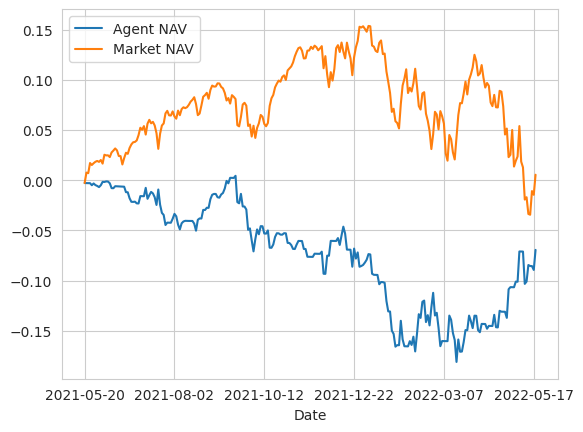

In [8]:
test_res[["Agent NAV","Market NAV"]].plot()

In [9]:
train_res = pd.read_csv(str(results_path) + "/training_results.csv", index_col = "Episode")
train_res

,Agent Ep NAV,Market Ep NAV,Agent CumSum NAV,Market CumSum NAV,Difference,Strategy Wins (%)
Episode,,,,,,
1,0.006843,0.022188,0.006843,0.022188,-0.015345,NaN
2,0.252072,0.109625,0.258914,0.131813,0.142446,NaN
3,0.193082,0.152393,0.451997,0.284206,0.040690,NaN
4,0.013080,0.132571,0.465077,0.416777,-0.119491,NaN
5,-0.073704,0.171274,0.391373,0.588051,-0.244978,NaN
6,-0.296538,0.062837,0.094836,0.650888,-0.359375,NaN
7,-0.001146,0.132237,0.093690,0.783125,-0.133382,NaN
8,0.149999,-0.102185,0.243689,0.680940,0.252184,NaN
9,0.170168,0.202797,0.413857,0.883737,-0.032630,NaN


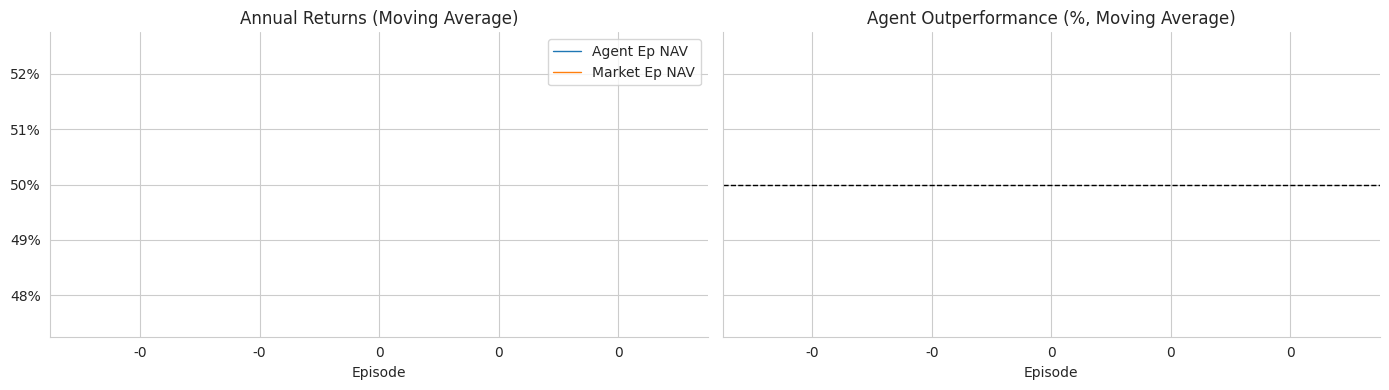

In [10]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 4), sharey=True)

df1 = (train_res[['Agent Ep NAV', 'Market Ep NAV']]
       .rolling(100) # was 100
       .mean())
df1.plot(ax=axes[0],
         title='Annual Returns (Moving Average)',
         lw=1)

df2 = train_res['Strategy Wins (%)'].div(100).rolling(50).mean() # was 100 and 50
df2.plot(ax=axes[1],
         title='Agent Outperformance (%, Moving Average)')

for ax in axes:
    ax.yaxis.set_major_formatter(
        FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
    ax.xaxis.set_major_formatter(
        FuncFormatter(lambda x, _: '{:,.0f}'.format(x)))
axes[1].axhline(.5, ls='--', c='k', lw=1)

sns.despine()
fig.tight_layout()
#fig.savefig(results_path / 'performance', dpi=300)                     # Save the pic

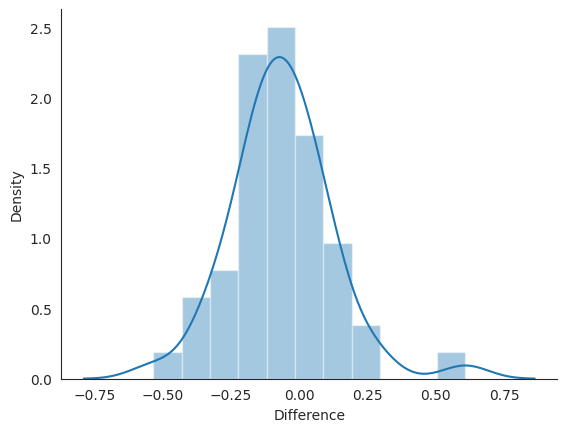

In [11]:
with sns.axes_style('white'):
    sns.distplot(train_res.Difference)
    sns.despine()